In [6]:
## import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/Adam/MNIST_data/",one_hot=True)


Extracting /Users/Adam/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/Adam/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/Adam/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/Adam/MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
## inspect shape of training and test datasets
print(mnist.train.images.shape)
print(mnist.test.images.shape)


(55000, 784)
(10000, 784)


In [67]:
## reset default graph
tf.reset_default_graph()

## set batch size
batch_size = 32

## set placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')


## -==================== DEFINE AUTOENCODER CLASS ====================- ##
class AutoEncoder:
    def __init__(self):

        self.dec_in_channels = 1
        self.reshaped_dim = [-1, 7, 7, self.dec_in_channels]
        self.inputs_decoder = 49 * self.dec_in_channels // 2

    ## define encoder architecture    
    def encoder(self, X, keep_prob, n_latent=8):
        activation = tf.nn.leaky_relu
        with tf.variable_scope("encoder", reuse=None):
            X = tf.reshape(X, shape=[-1, 28, 28, 1])

            self.encoder_input = X.get_shape()
            x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)

            self.encoder_conv1 = x.get_shape()
            x = tf.nn.dropout(x, keep_prob)
            x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)

            self.encoder_conv2 = x.get_shape()

            x = tf.nn.dropout(x, keep_prob)
            x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)

            self.encoder_conv3 = x.get_shape()

            x = tf.nn.dropout(x, keep_prob)
            x = tf.contrib.layers.flatten(x)
            mn = tf.layers.dense(x, units=n_latent)     

            self.encoder_dense = x.get_shape()

            sd       = 0.5 * tf.layers.dense(x, units=n_latent) 

            self.encoder_sd = sd.get_shape()
            self.encoder_mean = mn.get_shape()
            epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
            encoded = mn + tf.multiply(epsilon, tf.exp(sd))

            self.encoder_encoded = encoded.get_shape()
            
            self.encoded = encoded
            self.mn = mn
            self.sd = sd

            return encoded, mn, sd

    ## define decoder architecture
    def decoder(self, encoded, keep_prob):
        with tf.variable_scope("decoder", reuse=None):
            self.decoder_input = encoded.get_shape()
            x = tf.layers.dense(encoded, units=self.inputs_decoder, activation=tf.nn.leaky_relu)

            self.decoder_dense1 = x.get_shape()
            x = tf.layers.dense(x, units=self.inputs_decoder * 2 + 1, activation=tf.nn.leaky_relu)

            self.decoder_dense2 = x.get_shape()
            x = tf.reshape(x, self.reshaped_dim)
            x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
            
            self.decoder_deconv1 = x.get_shape()
            x = tf.nn.dropout(x, keep_prob)
            x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)

            self.decoder_deconv2 = x.get_shape()
            x = tf.nn.dropout(x, keep_prob)
            x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
            
            self.decoder_deconv3 = x.get_shape()
            x = tf.contrib.layers.flatten(x)
 
            self.decoder_flatten = x.get_shape()
            x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)

            self.decoder_denseOut = x.get_shape()
            decoded = tf.reshape(x, shape=[-1, 28, 28])
            
            self.decoder_final = decoded.get_shape()
            self.decoded = decoded
            return decoded
    
    ## define helper method for keeping track of dimensions - VERY useful when debugging!
    def architecture(self):
        print('--------------- ENCODER ---------------')
        
        print('input shape: {}'.format(self.encoder_input ))
        print('1st conv shape: {}'.format(self.encoder_conv1))
        print('2nd conv shape: {}'.format( self.encoder_conv2))
        print('3rd conv shape: {}'.format(self.encoder_conv3))
        print('dense output shape: {}'.format(self.encoder_dense))
        print('sd vector shape: {}'.format(self.encoder_sd))
        print('mean vector shape: {}'.format(self.encoder_mean)) 
        print('encoded shape: {}'.format(self.encoder_encoded))
        print('\n')
        print('--------------- DECODER ---------------')
        
        print('input shape: {}'.format(self.decoder_input))
        print('1st dense shape: {}'.format(self.decoder_dense1))
        print('2nd dense shape: {}'.format(self.decoder_dense2))
        print('1st deconvolutional shape: {}'.format(self.decoder_deconv1))
        print('2nd deconvolutional shape: {}'.format(self.decoder_deconv2))
        print('3rd deconvolutional shape: {}'.format(self.decoder_deconv3))        
        print('flattened shape: {}'.format(self.decoder_flatten))           
        print('dense output: {}'.format(self.decoder_denseOut))
        print('final reconstruction shape: {}'.format(self.decoder_final))
    
    ## define loss: combination of latent loss (KL divergence regularisation term) and reconstructions loss (MSE)
    def loss(self, X, decoded, mn, sd, alpha=0.5):
        img_loss = tf.reduce_sum(tf.squared_difference(tf.reshape(decoded, [-1, 28*28])
                                                       ,tf.reshape(X, shape=[-1, 28 * 28])), 1)
        latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
        recon_loss = 2*tf.reduce_mean(alpha*img_loss)
        variational_loss = 2*tf.reduce_mean((1-alpha)*latent_loss)
        return recon_loss, variational_loss, 2*tf.reduce_mean(alpha*img_loss + (1-alpha)*latent_loss)
 
    # define optimisation routine to use
    def optimize(self, loss, learning_rate=0.0005):
        return tf.train.AdamOptimizer(learning_rate).minimize(loss)

    ## define compare method to visually inspect input vs output
    def compare(self, orig, reconstructed):
        plt.imshow(np.reshape(orig, [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(reconstructed, cmap='gray')
        plt.show()


In [70]:
## instantiate Variational Autoencoder
VAE = AutoEncoder()

## set dimension of latent vectors by n_latent
encoded, mean, sd = VAE.encoder(X, keep_prob, n_latent = 16)
decoded = VAE.decoder(encoded, keep_prob)

## display architecture
VAE.architecture()

--------------- ENCODER ---------------
input shape: (?, 28, 28, 1)
1st conv shape: (?, 14, 14, 64)
2nd conv shape: (?, 7, 7, 64)
3rd conv shape: (?, 7, 7, 64)
dense output shape: (?, 3136)
sd vector shape: (?, 16)
mean vector shape: (?, 16)
encoded shape: (?, 16)


--------------- DECODER ---------------
input shape: (?, 16)
1st dense shape: (?, 24)
2nd dense shape: (?, 49)
1st deconvolutional shape: (?, 14, 14, 64)
2nd deconvolutional shape: (?, 14, 14, 64)
3rd deconvolutional shape: (?, 14, 14, 64)
flattened shape: (?, 12544)
dense output: (?, 784)
final reconstruction shape: (?, 28, 28)


iter 0 	 train loss = 181.7645263671875 	 test loss = 176.32272338867188
reconstruction iter :0


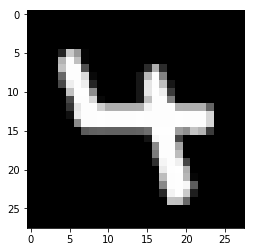

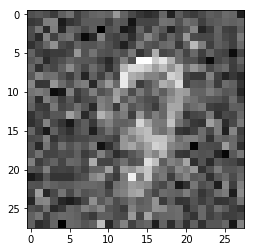

iter 50 	 train loss = 52.82059860229492 	 test loss = 55.564998626708984
iter 100 	 train loss = 50.38465118408203 	 test loss = 47.916099548339844
iter 150 	 train loss = 53.53785705566406 	 test loss = 56.66456985473633
iter 200 	 train loss = 50.48572540283203 	 test loss = 50.72947692871094
iter 250 	 train loss = 46.694847106933594 	 test loss = 54.09099578857422
iter 300 	 train loss = 43.41891098022461 	 test loss = 51.48448181152344
iter 350 	 train loss = 48.51543426513672 	 test loss = 49.06696701049805
iter 400 	 train loss = 48.07105255126953 	 test loss = 44.48291015625
iter 450 	 train loss = 46.90562438964844 	 test loss = 48.859092712402344
iter 500 	 train loss = 36.738224029541016 	 test loss = 44.783897399902344
reconstruction iter :500


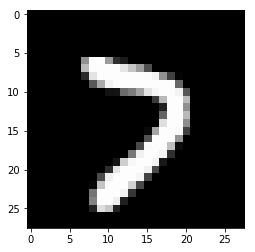

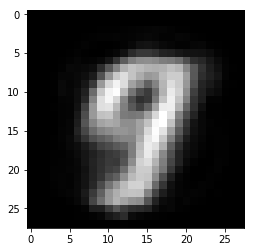

iter 550 	 train loss = 39.852394104003906 	 test loss = 45.26806640625
iter 600 	 train loss = 45.151084899902344 	 test loss = 43.12046432495117
iter 650 	 train loss = 42.04146194458008 	 test loss = 36.38111877441406
iter 700 	 train loss = 45.245323181152344 	 test loss = 42.88850784301758
iter 750 	 train loss = 40.75873565673828 	 test loss = 39.40871810913086
iter 800 	 train loss = 39.97331237792969 	 test loss = 38.79943084716797
iter 850 	 train loss = 42.72761535644531 	 test loss = 38.68876647949219
iter 900 	 train loss = 38.02272033691406 	 test loss = 36.81282043457031
iter 950 	 train loss = 39.06571960449219 	 test loss = 36.93897247314453
iter 1000 	 train loss = 36.93147277832031 	 test loss = 37.1844482421875
reconstruction iter :1000


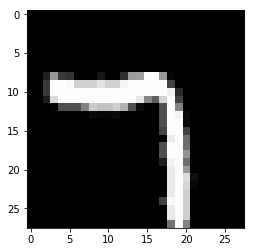

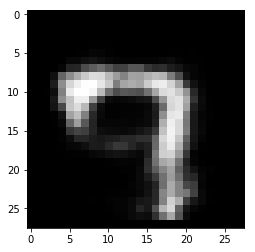

iter 1050 	 train loss = 40.188087463378906 	 test loss = 39.328834533691406
iter 1100 	 train loss = 43.59882354736328 	 test loss = 35.638465881347656
iter 1150 	 train loss = 41.60708999633789 	 test loss = 36.2746696472168
iter 1200 	 train loss = 39.69559097290039 	 test loss = 37.34967041015625
iter 1250 	 train loss = 39.127159118652344 	 test loss = 32.91357421875
iter 1300 	 train loss = 35.74771499633789 	 test loss = 33.81401824951172
iter 1350 	 train loss = 35.59334945678711 	 test loss = 36.17216873168945
iter 1400 	 train loss = 36.75926971435547 	 test loss = 35.6705436706543
iter 1450 	 train loss = 35.80759048461914 	 test loss = 37.056182861328125
iter 1500 	 train loss = 35.98973083496094 	 test loss = 36.300113677978516
reconstruction iter :1500


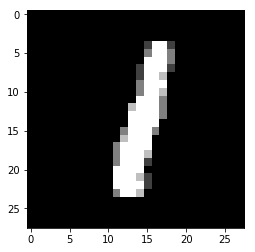

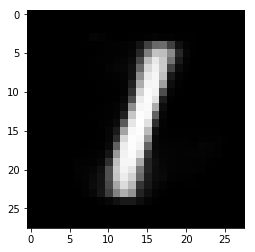

iter 1550 	 train loss = 33.55462646484375 	 test loss = 33.439056396484375
iter 1600 	 train loss = 38.80928039550781 	 test loss = 33.65521240234375
iter 1650 	 train loss = 34.58415985107422 	 test loss = 31.762863159179688
iter 1700 	 train loss = 33.227264404296875 	 test loss = 31.820634841918945
iter 1750 	 train loss = 36.59751892089844 	 test loss = 34.81517791748047
iter 1800 	 train loss = 35.87334060668945 	 test loss = 32.67894744873047
iter 1850 	 train loss = 36.247520446777344 	 test loss = 31.803482055664062
iter 1900 	 train loss = 30.188983917236328 	 test loss = 32.829620361328125
iter 1950 	 train loss = 36.2199821472168 	 test loss = 37.25957489013672
iter 2000 	 train loss = 37.85406494140625 	 test loss = 34.430946350097656
reconstruction iter :2000


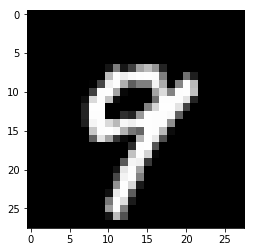

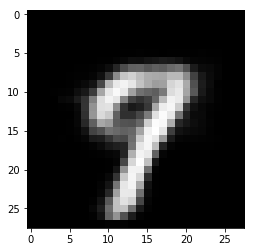

iter 2050 	 train loss = 37.11337661743164 	 test loss = 34.12860870361328
iter 2100 	 train loss = 32.33974838256836 	 test loss = 34.31610870361328
iter 2150 	 train loss = 37.54933166503906 	 test loss = 30.288822174072266
iter 2200 	 train loss = 35.16675567626953 	 test loss = 33.54828643798828
iter 2250 	 train loss = 34.31842041015625 	 test loss = 33.45072937011719
iter 2300 	 train loss = 31.91208267211914 	 test loss = 33.510982513427734
iter 2350 	 train loss = 33.87057113647461 	 test loss = 33.392425537109375
iter 2400 	 train loss = 34.50199508666992 	 test loss = 35.07843780517578
iter 2450 	 train loss = 35.66581344604492 	 test loss = 32.416351318359375
iter 2500 	 train loss = 34.772117614746094 	 test loss = 32.39509582519531
reconstruction iter :2500


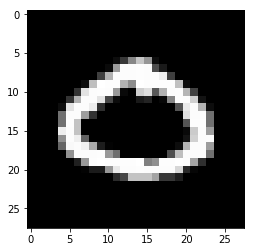

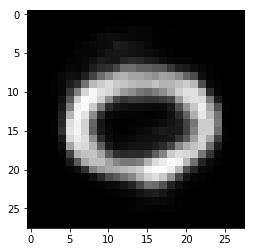

iter 2550 	 train loss = 30.832080841064453 	 test loss = 32.61668395996094
iter 2600 	 train loss = 35.312705993652344 	 test loss = 33.49666976928711
iter 2650 	 train loss = 32.800697326660156 	 test loss = 30.232507705688477
iter 2700 	 train loss = 34.09046936035156 	 test loss = 31.9692440032959
iter 2750 	 train loss = 35.3995246887207 	 test loss = 30.817607879638672
iter 2800 	 train loss = 34.2552604675293 	 test loss = 31.249183654785156
iter 2850 	 train loss = 35.134605407714844 	 test loss = 32.47889709472656
iter 2900 	 train loss = 34.093406677246094 	 test loss = 30.69650650024414
iter 2950 	 train loss = 33.393638610839844 	 test loss = 34.90164566040039
iter 3000 	 train loss = 31.96193504333496 	 test loss = 29.787395477294922
reconstruction iter :3000


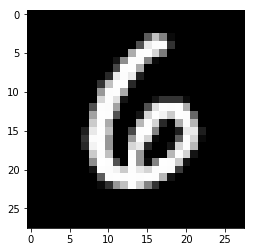

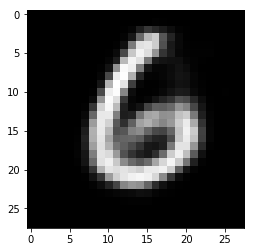

iter 3050 	 train loss = 32.971435546875 	 test loss = 33.329795837402344
iter 3100 	 train loss = 30.984176635742188 	 test loss = 32.163848876953125
iter 3150 	 train loss = 34.07809829711914 	 test loss = 32.84840774536133
iter 3200 	 train loss = 34.0440673828125 	 test loss = 32.371150970458984
iter 3250 	 train loss = 32.4739990234375 	 test loss = 32.60003662109375
iter 3300 	 train loss = 36.015724182128906 	 test loss = 32.6124267578125
iter 3350 	 train loss = 31.92178726196289 	 test loss = 32.46602249145508
iter 3400 	 train loss = 34.222412109375 	 test loss = 32.13992691040039
iter 3450 	 train loss = 34.86912536621094 	 test loss = 33.14495086669922
iter 3500 	 train loss = 31.674976348876953 	 test loss = 30.04581069946289
reconstruction iter :3500


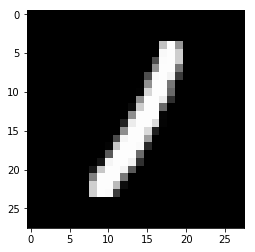

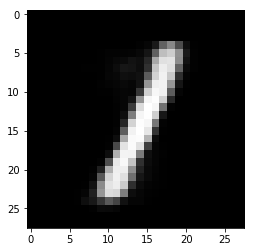

iter 3550 	 train loss = 32.62297058105469 	 test loss = 29.59756088256836
iter 3600 	 train loss = 30.699581146240234 	 test loss = 34.316650390625
iter 3650 	 train loss = 31.91370964050293 	 test loss = 31.57930564880371
iter 3700 	 train loss = 33.12043762207031 	 test loss = 31.93052864074707
iter 3750 	 train loss = 32.109832763671875 	 test loss = 35.99842834472656
iter 3800 	 train loss = 33.1450309753418 	 test loss = 31.107730865478516
iter 3850 	 train loss = 33.8218994140625 	 test loss = 32.881797790527344
iter 3900 	 train loss = 31.947118759155273 	 test loss = 32.45622634887695
iter 3950 	 train loss = 32.286773681640625 	 test loss = 31.70992660522461
iter 4000 	 train loss = 31.722835540771484 	 test loss = 28.991291046142578
reconstruction iter :4000


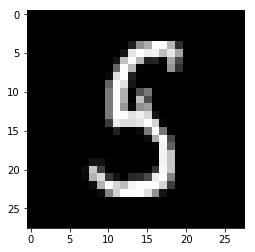

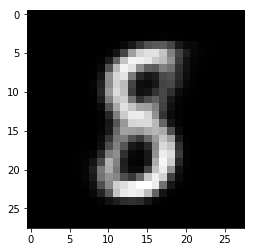

iter 4050 	 train loss = 30.916120529174805 	 test loss = 30.38848114013672
iter 4100 	 train loss = 33.900413513183594 	 test loss = 30.922649383544922
iter 4150 	 train loss = 33.16162109375 	 test loss = 30.188220977783203
iter 4200 	 train loss = 33.6046142578125 	 test loss = 33.3847770690918
iter 4250 	 train loss = 31.353334426879883 	 test loss = 32.04143524169922
iter 4300 	 train loss = 33.266998291015625 	 test loss = 31.62938117980957
iter 4350 	 train loss = 32.9661865234375 	 test loss = 31.11192512512207
iter 4400 	 train loss = 32.43212127685547 	 test loss = 30.56684684753418
iter 4450 	 train loss = 33.836570739746094 	 test loss = 30.545015335083008
iter 4500 	 train loss = 32.94103240966797 	 test loss = 32.11140441894531
reconstruction iter :4500


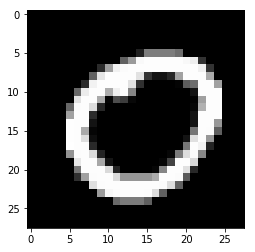

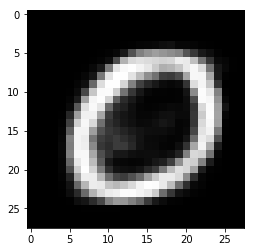

iter 4550 	 train loss = 28.986209869384766 	 test loss = 32.00975799560547
iter 4600 	 train loss = 33.17729949951172 	 test loss = 30.995203018188477
iter 4650 	 train loss = 32.379058837890625 	 test loss = 31.6457576751709
iter 4700 	 train loss = 29.319656372070312 	 test loss = 29.933055877685547
iter 4750 	 train loss = 34.34687805175781 	 test loss = 29.300384521484375
iter 4800 	 train loss = 27.273420333862305 	 test loss = 33.276153564453125
iter 4850 	 train loss = 31.83747100830078 	 test loss = 29.522369384765625
iter 4900 	 train loss = 29.17078399658203 	 test loss = 32.706939697265625
iter 4950 	 train loss = 32.11662673950195 	 test loss = 30.77988624572754


In [73]:
reconstruction_loss, variational_loss, loss = VAE.loss(X, decoded, mean, sd, alpha=0.5)
#optim = VAE.optimize(loss,learning_rate=0.0005)
optim = VAE.optimize(loss,learning_rate=0.0005)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter("/Users/Adam/Documents/Python/Autoencoder/tensorboard", sess.graph)
#writer_test = tf.summary.FileWriter("/Users/Adam/Documents/Python/Autoencoder/tensorboard/test", tf.get_default_graph())
train_loss_tracker = []
test_loss_tracker = []

loss_summ = tf.summary.scalar('loss', loss)
#for i in range(5000):
for i in range(5000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    _, train_loss, train_loss_summ = sess.run([optim,loss,loss_summ],feed_dict = {X: batch,keep_prob: 0.8})
    writer.add_summary(train_loss_summ, i)
    if i % 50 == 0:
        batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
        test_loss, enc, dec, mu, sigm = sess.run([loss,encoded,decoded,mean,sd],feed_dict = {X: batch
                                                                                                ,keep_prob: 1.0})
        print("iter {0} \t train loss = {1} \t test loss = {2}".format(i,train_loss,test_loss))

        train_loss_tracker.append(train_loss)
        test_loss_tracker.append(test_loss)

    if i % 500 == 0:
        print("reconstruction iter :{}".format(i))
        VAE.compare(batch[0], dec[0])
#        print("iter {0} \t train loss = {1} \t test loss = {2} \t test recon loss = {3} \t test var loss = {4}".format(i
#                                                                                                                       ,train_loss
#                                                                                                                       ,test_loss
#                                                                                                                       ,test_recon_loss
#                                                                                                                       ,test_var_loss))

#       print("train recon loss = {1} \t train var loss = {2}".format(i,train_recon_loss,train_var_loss))
#         
#        writer_test.add_summary(test_loss, i).eval() 


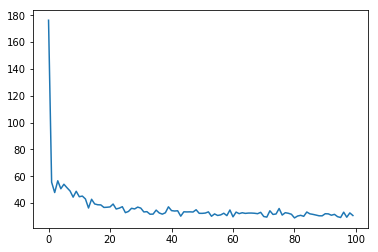

In [118]:
## check loss over time
import matplotlib.pyplot as plt
plt.plot(test_loss_tracker)

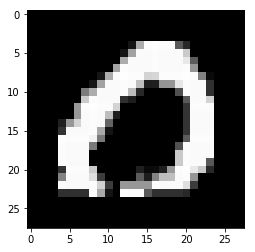

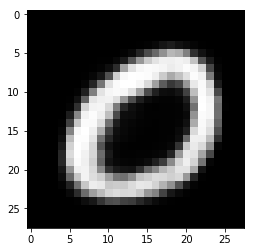

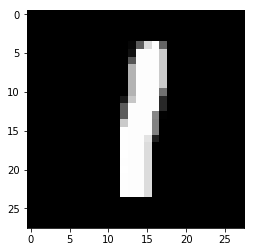

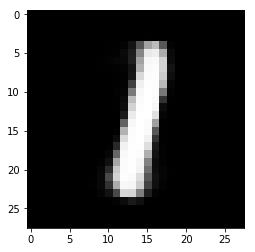

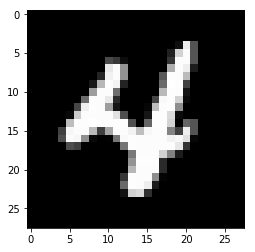

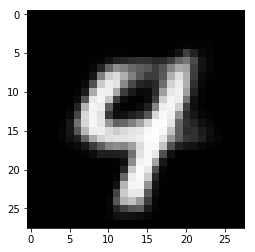

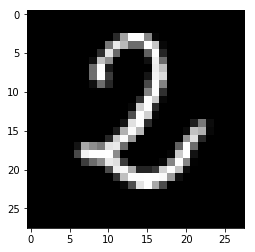

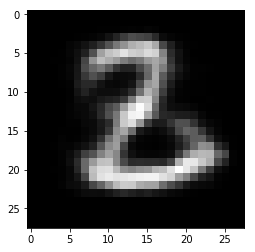

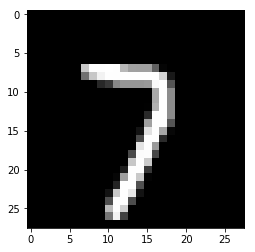

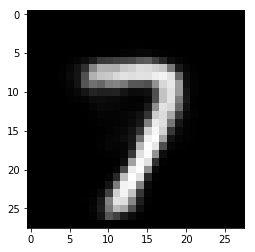

In [145]:
from random import seed
from random import sample

# want to encode/decode some samples from batch and see how they compare
batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
_, _, dec, _, _ = sess.run([loss,encoded,decoded,mean,sd],feed_dict = {X: batch ,keep_prob: 1.0})

# set seed if you want reproducibility
#seed(1)

# select a subset of length 5 without replacement
sequence = [i for i in range(len(batch))]
subset = sample(sequence, 5)

## let's have a look!
for i in subset:
    [VAE.compare(batch[i], dec[i])]

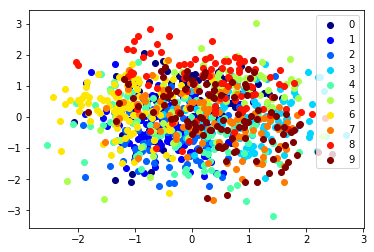

In [117]:
## check distribution of latent vectors in latent space - this only makes sense 
## when the dimension of our latent vectors is 2!
batch = np.reshape(mnist.train.images[0:1000],[1000,28,28])
labels = [np.nonzero(mnist.train.labels[i])[0][0] for i in range(len(batch))]

imgs = sess.run(encoded, feed_dict = {X: batch, keep_prob: 1.0})
x = [imgs[i,0] for i in range(len(batch))]
y = [imgs[i,1] for i in range(len(batch))]

unique = list(set(labels))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if labels[j] == u]
    yi = [y[j] for j  in range(len(x)) if labels[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u))
plt.legend()

plt.show()

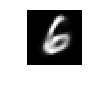

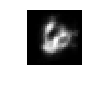

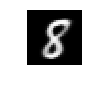

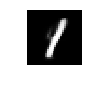

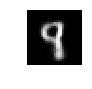

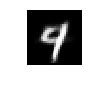

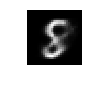

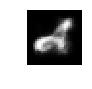

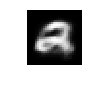

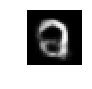

In [113]:
## genertate some examples
randoms = [np.random.normal(0, 1, 16) for _ in range(10)]
imgs = sess.run(decoded, feed_dict = {encoded: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

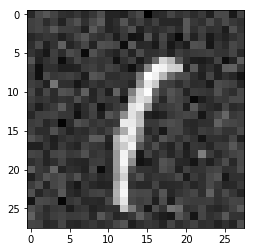

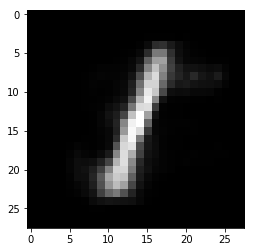

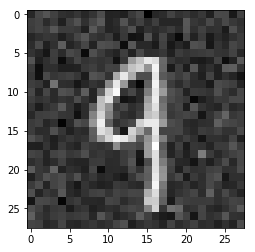

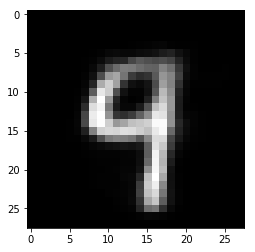

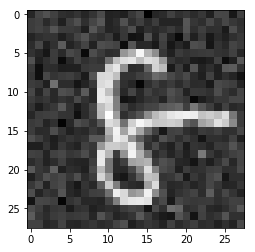

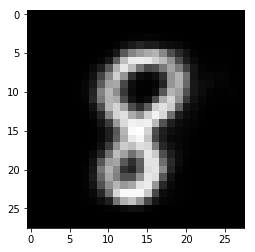

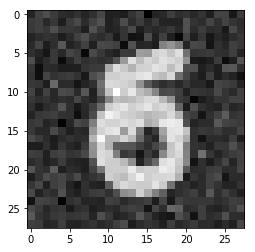

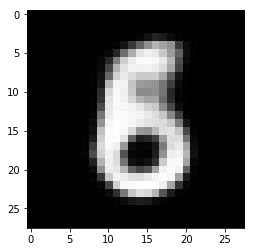

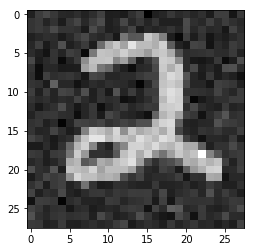

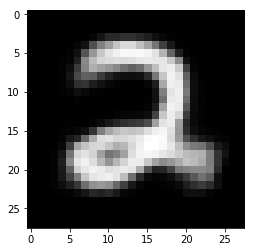

In [188]:
## add Gaussian noise
batch_noised = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=10)[0]+np.random.normal(0,1,784)/10]
_, _, dec_denoised, _, _ = sess.run([loss,encoded,decoded,mean,sd],feed_dict = {X: batch_noised ,keep_prob: 1.0})

## see how the reconstruction of the noisy input looks
for i in range(len(batch_noised)//2):
    [VAE.compare(batch_noised[i], dec_denoised[i])]